In [1]:
!pip install pandas numpy matplotlib seaborn nltk tqdm datasets scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 1.2 MB/s eta 0:00:00:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from tqdm import tqdm
from datasets import load_dataset, load_from_disk

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

## Load datasets

In [4]:
from huggingface_hub import login

login()

In [8]:
# Load dataset
dataset_large = load_dataset("chcaa/periphery-aviser-e5", split='train')

df = dataset_large.to_pandas()
df.shape

(866977, 13)

In [9]:
df = df_large

In [10]:
# Load dataset with extra articles
dataset = load_from_disk("../../../ROOT/DATA/NEWSPAPERS/backup_extra_newspapers_250624")

df_extra = dataset.to_pandas()
df_extra.shape

(372227, 11)

In [11]:
df.groupby(['label_type', 'newspaper'])['newspaper'].count()

label_type  newspaper
gold        aal             200
            lol           85092
            ode             196
            thi             200
            vib             194
predicted   aal          155811
            aar          181956
            ode          201982
            thi           71902
            vib          169444
Name: newspaper, dtype: int64

In [7]:
df.columns

Index(['article_id', 'date', 'embedding', 'n_chunks_orig', 'clean_category',
       'nøgle', 'text', 'category', 'article_length', 'characters',
       'embedding_shape', 'newspaper', 'label_type'],
      dtype='object')

In [12]:
# Load annotated books subset
book_gold = pd.read_csv('../../newspaper_temp_files/annotated_books_gold_250503.csv', index_col=0)
book_gold.head()

,article_id,book_announce,comment
264863,ode_023787,y,NaN
151177,aal_066100,n,mixed
379019,ode_138229,n,NaN
483748,thi_040569,n,mixed
369240,ode_128401,n,NaN


In [13]:
book_gold['book_announce'].value_counts()

book_announce
n    622
y    281
Name: count, dtype: int64

In [14]:
df = df.merge(book_gold, on='article_id', how='left')
df['book_announce'] = df['book_announce'].fillna('unknown')

In [15]:
df.groupby('book_announce')['book_announce'].count()

book_announce
n             622
unknown    866084
y             271
Name: book_announce, dtype: int64

In [16]:
df['book_announce'].value_counts()

book_announce
unknown    866084
n             622
y             271
Name: count, dtype: int64

In [16]:
df['comment'].value_counts()

comment
header                                      111
mixed                                        88
journal announcement                         18
journal announcement                         10
calendar announcement                         6
theater                                       3
journal                                       1
calendar                                      1
calender announcement                         1
note: is an individual (personal) seller      1
Name: count, dtype: int64

## 1. Classifier with unlabeled announcements and book announcements

Balanced sample performs better than unbalanced sample. The merged_sample does not contain mixed book announcements.

In [23]:
# Create sample of unlabeled announcements
unlabeled_df = df[(df['book_announce'] == 'unknown') & (df['clean_category'] == 'Bekjendtgjørelser')]
random_sample_unlabeled = unlabeled_df.sample(n=260, random_state=42)

# Create sample of labeled book announcements
random_sample_books = df[(df['book_announce'] == 'y') & (df['comment'] != 'mixed')].sample(n=260, random_state=42)

merged_sample = pd.concat([random_sample_unlabeled, random_sample_books])
merged_sample.shape

(520, 15)

### 1.1 Without cross-validation

In [24]:
# Split the balanced data into train and test sets with stratification
train_df, test_df = train_test_split(
    merged_sample, 
    test_size=0.3, 
    random_state=42, 
    stratify=merged_sample['book_announce']
)

# Prepare training and test features/labels
X_train = np.vstack(train_df['embedding'].values)
y_train = train_df['book_announce'].values

X_test = np.vstack(test_df['embedding'].values)
y_test = test_df['book_announce'].values

# Instantiate the Logistic Regression classifier
clf_embs = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the classifier on the labeled training data
print(f'Train classifier on embeddings')
clf_embs.fit(X_train, y_train)

# Evaluate on the test set
predictions = clf_embs.predict(X_test)
print(classification_report(y_test, predictions))

Train classifier on embeddings


              precision    recall  f1-score   support

     unknown       0.97      0.95      0.96        78
           y       0.95      0.97      0.96        78

    accuracy                           0.96       156
   macro avg       0.96      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156



### 1.2 With cross-validation

In [25]:
# Prepare the data
X = np.vstack(merged_sample['embedding'].values)
y = merged_sample['book_announce'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Get classification report as a dictionary
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics across all folds
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame for better formatting
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds:")
print(avg_df)


📊 Average Per-Class Metrics Across Folds:
         precision    recall  f1-score  support
unknown   0.988311  0.946154  0.966357     52.0
y         0.949329  0.988462  0.968174     52.0


## 2. Classifier with non-book announcements and book announcements

In [18]:
# Define the number of samples per class (adjust based on dataset size)
n_samples_per_class = 260  # Change as needed

df_books = df[(df['book_announce'] != 'unknown') & (df['comment'] != 'mixed')]

# Create a balanced dataset by sampling an equal number of instances per class
df_balanced = df_books.groupby('book_announce', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), n_samples_per_class), random_state=42)
)

/tmp/ipykernel_10214/1502793623.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_books.groupby('book_announce', group_keys=False).apply(


### 2.1 Embeddings without cross-validation

In [27]:
# Split the balanced data into train and test sets with stratification
train_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_balanced['book_announce']
)

# Prepare training and test features/labels
X_train = np.vstack(train_df['embedding'].values)
y_train = train_df['book_announce'].values

X_test = np.vstack(test_df['embedding'].values)
y_test = test_df['book_announce'].values

# Instantiate the Logistic Regression classifier
clf_embs = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the classifier on the labeled training data
print(f'Train classifier on embeddings')
clf_embs.fit(X_train, y_train)

# Evaluate on the test set
predictions = clf_embs.predict(X_test)
print(classification_report(y_test, predictions))

Train classifier on embeddings
              precision    recall  f1-score   support

           n       0.87      0.94      0.90        78
           y       0.93      0.86      0.89        78

    accuracy                           0.90       156
   macro avg       0.90      0.90      0.90       156
weighted avg       0.90      0.90      0.90       156



### 2.2 Embeddings with cross-validation: continue with this model

In [19]:
# Prepare the data
X = np.vstack(df_balanced['embedding'].values)
y = df_balanced['book_announce'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Get classification report as a dictionary
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics across all folds
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame for better formatting
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds:")
print(avg_df)

📊 Average Per-Class Metrics Across Folds:
   precision    recall  f1-score  support
n   0.923931  0.903846  0.913052     52.0
y   0.906009  0.923077  0.913677     52.0


### 2.3 TFIDF without cross-validation

In [29]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit on training data and transform both train and test sets
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

# Prepare labels
y_train = train_df['book_announce'].values
y_test = test_df['book_announce'].values

# Instantiate the Logistic Regression classifier
clf_tfidf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the classifier on the TF-IDF features
print(f'Train classifier on TF-IDF features')
clf_tfidf.fit(X_train, y_train)

# Evaluate on the test set
predictions = clf_tfidf.predict(X_test)
print(classification_report(y_test, predictions))

Train classifier on TF-IDF features
              precision    recall  f1-score   support

           n       0.89      0.94      0.91        78
           y       0.93      0.88      0.91        78

    accuracy                           0.91       156
   macro avg       0.91      0.91      0.91       156
weighted avg       0.91      0.91      0.91       156



In [30]:
# Prepare data
texts = df_balanced['text'].values
labels = df_balanced['book_announce'].values

# Encode labels if needed
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
class_names = le.classes_

# Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

for train_index, test_index in skf.split(texts, y_encoded):
    X_train_texts, X_test_texts = texts[train_index], texts[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Vectorize text
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(X_train_texts)
    X_test = vectorizer.transform(X_test_texts)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Classification report per fold
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds (TF-IDF):")
print(avg_df)

📊 Average Per-Class Metrics Across Folds (TF-IDF):
   precision    recall  f1-score  support
n   0.915618  0.888462  0.901161     52.0
y   0.891260  0.915385  0.902533     52.0


## 3. Classifier with mixed book announcements

### 3.1 Mixed announcements as separate class

In [31]:
# Create sample of unlabeled announcements
unlabeled_df = df[(df['book_announce'] == 'unknown') & (df['clean_category'] == 'Bekjendtgjørelser')]
random_sample_unlabeled = unlabeled_df.sample(n=88, random_state=42)

# Create sample of labeled book announcements
random_sample_books = df[df['book_announce'] == 'y'].sample(n=88, random_state=42)

# Create sample of mixed book announcements
random_mixed_books = df[df['comment'] == 'mixed'].sample(n=88, random_state=42)

merged_mixed_sample = pd.concat([random_sample_unlabeled, random_sample_books, random_mixed_books])
merged_mixed_sample.shape

# Make all mixed book announcement 'mixed'
merged_mixed_sample.loc[merged_mixed_sample['comment'] == 'mixed', 'book_announce'] = 'mixed'

📊 Average Per-Class Metrics Across Folds:
         precision    recall  f1-score  support
mixed     0.706101  0.807602  0.750604     18.6
unknown   0.873457  0.854248  0.861443     17.6
y         0.883492  0.760294  0.812539     16.6


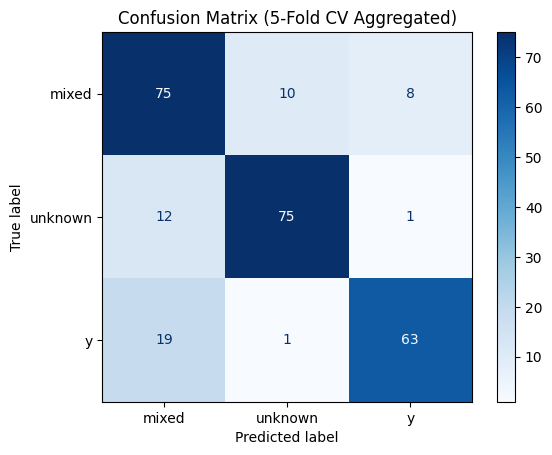

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare the data
X = np.vstack(merged_mixed_sample['embedding'].values)
y = merged_mixed_sample['book_announce'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

# For confusion matrix
all_y_true = []
all_y_pred = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Store predictions and true labels
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics across all folds
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds:")
print(avg_df)

# 🔲 Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (5-Fold CV Aggregated)")
plt.show()


### 3.2 Mixed announcements as 'y'

In [19]:
# Create sample of unlabeled announcements
unlabeled_df = df[(df['book_announce'] == 'unknown') & (df['clean_category'] == 'Bekjendtgjørelser')]
random_sample_unlabeled = unlabeled_df.sample(n=331, random_state=42)

# Create sample of labeled book announcements
random_sample_books = df[df['book_announce'] == 'y'].sample(n=243, random_state=42)

# Create sample of mixed book announcements
random_mixed_books = df[df['comment'] == 'mixed'].sample(n=88, random_state=42)

merged_mixed_sample = pd.concat([random_sample_unlabeled, random_sample_books, random_mixed_books])
print(merged_mixed_sample.shape)

# Make all mixed book announcement 'mixed'
merged_mixed_sample.loc[merged_mixed_sample['comment'] == 'mixed', 'book_announce'] = 'y'

(662, 15)


📊 Average Per-Class Metrics Across Folds:
         precision    recall  f1-score  support
unknown   0.882634  0.927363  0.903859     66.2
y         0.925198  0.876210  0.899391     66.2


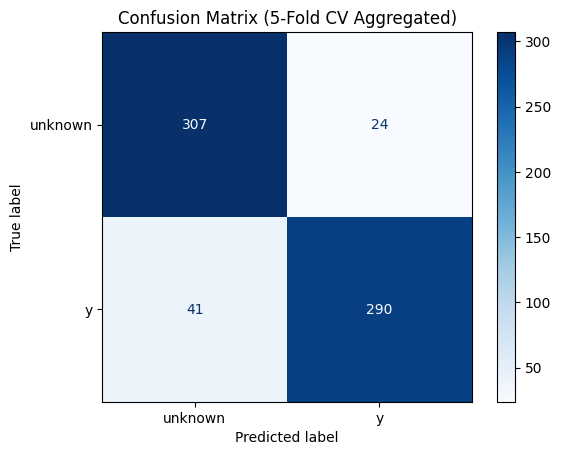

In [20]:
# Prepare the data
X = np.vstack(merged_mixed_sample['embedding'].values)
y = merged_mixed_sample['book_announce'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

# For confusion matrix
all_y_true = []
all_y_pred = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Store predictions and true labels
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics across all folds
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds:")
print(avg_df)

# 🔲 Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (5-Fold CV Aggregated)")
plt.show()

### 3.3 Mixed announcements as 'unknown'

In [23]:
# Create sample of unlabeled announcements
unlabeled_df = df[(df['book_announce'] == 'unknown') & (df['clean_category'] == 'Bekjendtgjørelser')]
random_sample_unlabeled = unlabeled_df.sample(n=155, random_state=42)

# Create sample of labeled book announcements
random_sample_books = df[(df['book_announce'] == 'y') & (df['comment'] != 'mixed')].sample(n=243, random_state=42)

# Create sample of mixed book announcements
random_mixed_books = df[df['comment'] == 'mixed'].sample(n=88, random_state=42)

merged_mixed_sample = pd.concat([random_sample_unlabeled, random_sample_books, random_mixed_books])
print(merged_mixed_sample.shape)

# Make all mixed book announcement 'mixed'
merged_mixed_sample.loc[merged_mixed_sample['comment'] == 'mixed', 'book_announce'] = 'unknown'

(486, 15)


📊 Average Per-Class Metrics Across Folds:
         precision    recall  f1-score  support
unknown   0.974926  0.880697  0.922934     48.6
y         0.895912  0.975340  0.932067     48.6


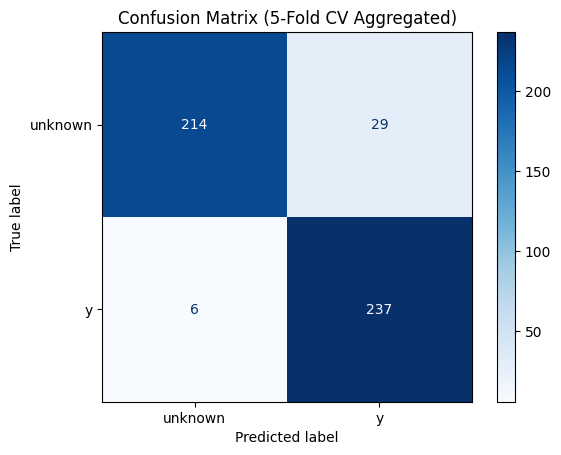

In [24]:
# Prepare the data
X = np.vstack(merged_mixed_sample['embedding'].values)
y = merged_mixed_sample['book_announce'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

# For confusion matrix
all_y_true = []
all_y_pred = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Store predictions and true labels
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics across all folds
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds:")
print(avg_df)

# 🔲 Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (5-Fold CV Aggregated)")
plt.show()

### 3.4 Only mixed announcements and no-book announcements

In [26]:
# Create sample of labeled no-book announcements
random_sample_books = df[(df['book_announce'] == 'n') & (df['comment'] != 'mixed')].sample(n=88, random_state=42)

# Create sample of mixed book announcements
random_mixed_books = df[df['comment'] == 'mixed'].sample(n=88, random_state=42)

merged_mixed_sample = pd.concat([random_sample_books, random_mixed_books])
print(merged_mixed_sample.shape)

# Make all mixed book announcement 'mixed'
merged_mixed_sample.loc[merged_mixed_sample['comment'] == 'mixed', 'book_announce'] = 'mixed'

(176, 15)


📊 Average Per-Class Metrics Across Folds:
       precision    recall  f1-score  support
mixed   0.659259  0.943791  0.775586     17.6
n       0.905455  0.511765  0.651484     17.6


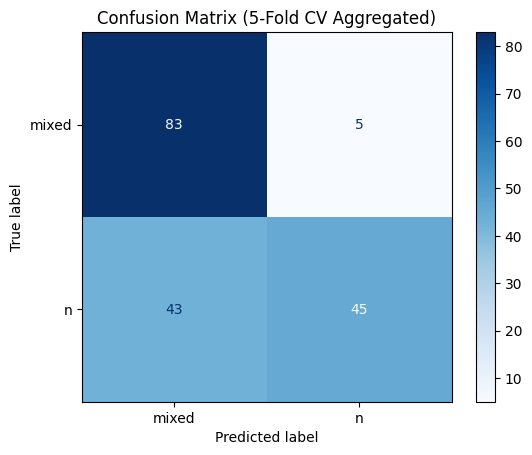

In [27]:
# Prepare the data
X = np.vstack(merged_mixed_sample['embedding'].values)
y = merged_mixed_sample['book_announce'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []

# For confusion matrix
all_y_true = []
all_y_pred = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Store predictions and true labels
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    all_reports.append(report)

# Average per-class metrics across all folds
avg_report = {}
for cls in class_names:
    avg_report[cls] = {
        metric: np.mean([fold[cls][metric] for fold in all_reports])
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

# Convert to DataFrame
avg_df = pd.DataFrame(avg_report).T
print("📊 Average Per-Class Metrics Across Folds:")
print(avg_df)

# 🔲 Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (5-Fold CV Aggregated)")
plt.show()

### Label unlabeled articles as book announcement

In [21]:
df_extra.columns

Index(['article_id', 'date', 'embedding', 'n_chunks_orig', 'clean_category',
       'text', 'article_length', 'characters', 'embedding_shape', 'newspaper',
       'label_type'],
      dtype='object')

In [22]:
pred_df = df_extra[df_extra['clean_category'] == 'Bekjendtgjørelser']
pred_df.shape

(132748, 11)

In [23]:
# Only get the announcements that have not been categorized as book anouncement yet
#pred_df = df[(df['book_announce'] == 'unknown') & (df['clean_category'] == 'Bekjendtgjørelser')]
pred_df = df_extra[df_extra['clean_category'] == 'Bekjendtgjørelser']
print(pred_df.shape)

# Identify the top 188 most frequent 'text' values (appearing 5 times or more)
top_188_texts = pred_df.groupby('text')['text'].count().sort_values(ascending=False).head(188).index

# Remove rows in 'pred_df' where the 'text' is in the top 188 texts
pred_df = pred_df[~pred_df['text'].isin(top_188_texts)]

# Remove lottery results
pred_df = pred_df[~pred_df['text'].str.contains(r'Ved Tallotteriets \S+ Trækning i', regex=True)]

# Remove very long and short articles
pred_df = pred_df[(pred_df['characters'] >= 70) & (pred_df['characters'] <= 500)]
print(pred_df.shape)

(132748, 11)
(77287, 11)


In [24]:
X_unlabeled = np.vstack(pred_df['embedding'].values)

In [25]:
# Predict labels
y_unlabeled_pred = clf.predict(X_unlabeled)

# Decode predicted class labels back to original strings
predicted_labels = le.inverse_transform(y_unlabeled_pred)

# Store predictions in your DataFrame
pred_df['predicted_book_announce'] = predicted_labels

In [26]:
pred_df['predicted_book_announce'].value_counts()

predicted_book_announce
n    74116
y     3171
Name: count, dtype: int64

In [29]:
pred_df.head()

,article_id,date,embedding,n_chunks_orig,clean_category,text,article_length,characters,embedding_shape,newspaper,label_type,predicted_book_announce
31,aar_182232,1830-01-01,"[0.01646844483911991, 0.012904197908937931, -0...",1,Bekjendtgjørelser,At de danske Kjøbstæders Brandforsikkrings Reg...,43,317,[1024],aar,predicted,n
32,aar_182233,1830-01-01,"[-0.002823864109814167, -0.003035525558516383,...",1,Bekjendtgjørelser,Efter Reqvisition af Justitsr. Dr. Seidelin fo...,52,371,[1024],aar,predicted,n
33,aar_182234,1830-01-01,"[0.03231672942638397, 0.01021607220172882, -0....",1,Bekjendtgjørelser,"Efter Reqvisition af Birkedommer Rasmus sen, f...",51,340,[1024],aar,predicted,n
35,aar_182236,1830-01-01,"[0.026176076382398605, 0.010067477822303772, -...",1,Bekjendtgjørelser,Jeg tillader mig desaarsag at anbefale Fabrikk...,43,283,[1024],aar,predicted,n
36,aar_182237,1830-01-01,"[0.0023201184812933207, 0.01591889001429081, -...",1,Bekjendtgjørelser,"Christiansfeldter Læder og Skind, Stærk og god...",25,179,[1024],aar,predicted,n


In [27]:
df['book_announce'].value_counts()

book_announce
unknown    866084
n             622
y             271
Name: count, dtype: int64

In [42]:
book_announces = pd.concat([pred_df[pred_df['predicted_book_announce'] == 'y'], df[df['book_announce'] == 'y']])
book_announces.shape

(7531, 16)

In [30]:
pred_df[pred_df['predicted_book_announce'] == 'y'].to_csv('../data/book_announces_extra_250624.csv')